# Stratified

This notebook contains the stratified training procedure.

In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import rouge

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from helpers import *
from visualization import *
from redundancy import *
from relevance import *
from preprocessing import *
from datasets import *
from models import *

from config import *
from config_models import *

torch.manual_seed(42)
cuda = torch.device('cuda:1')

### Globals

In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

### Setup

In [3]:
tuples_data = []
for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    tuples_data.extend(make_tuples_data_for_regression(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_train_regression, tuples_val_regression = stratified_sampling(tuples_data)

tuples_train_regression.shape, tuples_val_regression.shape

((2082, 3), (893, 3))

In [4]:
tuples_data = []
for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
    tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_train_classification, tuples_test_classification = stratified_sampling(tuples_data)

tuples_train_classification.shape, tuples_test_classification.shape

((126989, 4), (54425, 4))

## Transformation - Sinkhorn - Regression

Train Loss: 0.1798
Train Loss: 0.0182
Train Loss: 0.0014
Train Loss: 0.1971
Train Loss: 0.0918
Train Loss: 0.1632
Train Loss: 0.0106
Train Loss: 0.0581
Train Loss: 0.0900
Train Loss: 0.1640
Train Loss: 0.0076
Train Loss: 0.0149
Train Loss: 0.0117
Train Loss: 0.2500
Train Loss: 0.1170
Train Loss: 0.1656
Train Loss: 0.1560
Train Loss: 0.0571
Train Loss: 0.1798
Train Loss: 0.0012
Train Loss: 0.0342
Train Loss: 0.0400
Train Loss: 0.0581
Train Loss: 0.1714
Train Loss: 0.0035
Train Loss: 0.8855
Train Loss: 0.7090
Train Loss: 0.0718
Train Loss: 0.0190
Train Loss: 0.0480
Train Loss: 0.1246
Train Loss: 0.3832
Train Loss: 0.0992
Train Loss: 0.1190
Train Loss: 0.0961
Train Loss: 0.1798
Train Loss: 0.0317
Train Loss: 0.0292
Train Loss: 0.0543
Train Loss: 0.3516
Train Loss: 0.0357
Train Loss: 0.0088
Train Loss: 0.0713
Train Loss: 0.0000
Train Loss: 0.4747
Train Loss: 0.2927
Train Loss: 0.0174
Train Loss: 0.2694
Train Loss: 0.0400
Train Loss: 0.0055
Train Loss: 0.1936
Train Loss: 0.1030
Train Loss: 

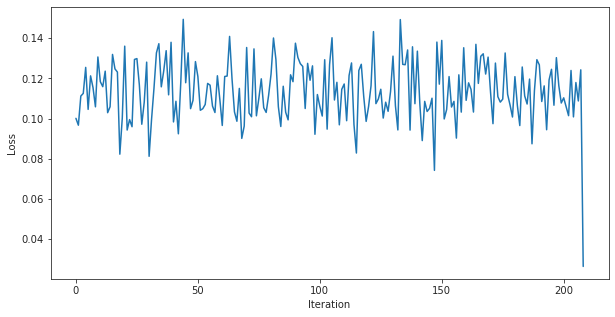

In [6]:
config = CONFIG_MODELS['TransformSinkhornRegModel']

transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetRegression(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_regression)
data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

transform_sinkhorn_reg_model = TransformSinkhornRegModel(config).to(device=cuda)

criterion = nn.MSELoss()
optimizer = optim.SGD(transform_sinkhorn_reg_model.parameters(), lr=config['learning_rate'])

loss = []

optimizer.zero_grad()

for batch in data_loader:
    
    for sample in batch:
        (d, s), y = transform(sample)

        y_hat = transform_sinkhorn_reg_model(d.to(device=cuda),
                                             s.to(device=cuda))
        
        L = criterion(y_hat, y.to(device=cuda))
        
        L.backward()
        
        loss.append(L.item())
        
    optimizer.step()
    
    optimizer.zero_grad()
    
    print(f'Train Loss: {loss[-1]:.4f}')

transform_sinkhorn_reg_model.save('transform_sinkhorn_reg_model.pt')

n = config['batch_size']
loss = [sum(loss[i:i+n])/n for i in range(0,len(loss),n)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Transformation - Sinkhorn - Pairwise Ranking

Train Loss: 0.0004
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 15.7214
Train Loss: 0.0000
Train Loss: 19.1238
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0118
Train Loss: 7.0128
Train Loss: 0.0012
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0005
Train Loss: 0.3895
Train Loss: 3.4408
Train Loss: 11.6117
Train Loss: 0.0000
Train Loss: 0.0454
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 2.8875
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 10.8861
Train Loss: 4.9915
Train Loss: 0.0003
Train Loss: 3.5905
Train Loss: 0.0001
Train Loss: 0.0031
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0002
Train Loss: 0.3188
Train Loss: 14.3329
Train Loss: 11.4035
Train Loss: 9.8364
Train Loss: 7.4383
Train Loss: 7.7751
Train Loss: 0.0000
Train Loss: 0.0004
Train Loss: 0.0000
Train Loss: 11.0053
Train Loss: 1.8847
Train Loss: 15.7678
Train Loss: 2.1079
Train Loss: 0.0922
Train Loss: 0.3600
Train Loss: 0.4869
Train Loss: 0.0000
Trai

Train Loss: 0.1680
Train Loss: 27.6310
Train Loss: 11.0079
Train Loss: 0.0000
Train Loss: 1.5127
Train Loss: 0.0018
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 3.4999
Train Loss: 0.2046
Train Loss: 0.0000
Train Loss: 20.6262
Train Loss: 27.4577
Train Loss: 0.0001
Train Loss: 0.0000
Train Loss: 4.2277
Train Loss: 0.0000
Train Loss: 0.0001
Train Loss: 0.0000
Train Loss: 1.5637
Train Loss: 0.0000
Train Loss: 1.6303
Train Loss: 15.4826
Train Loss: 0.3126
Train Loss: 0.0897
Train Loss: 0.0341
Train Loss: 6.6737
Train Loss: 7.9101
Train Loss: 0.0000
Train Loss: 5.4740
Train Loss: 0.0000
Train Loss: 0.0001
Train Loss: 4.0379
Train Loss: 18.2052
Train Loss: 0.0321
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 10.8195
Train Loss: 21.2321
Train Loss: 0.0000
Train Loss: 5.0124
Train Loss: 0.0001
Train Loss: 0.0000
Train Loss: 0.0004
Train Loss: 0.0024
Train Loss: 0.0005
Train Loss: 4.6950
Train Loss: 3.2222
Train Loss: 3.5624
Train Loss: 3.4344
Train Loss: 0.0029
Train Loss: 0.0044
Trai

Train Loss: 0.0015
Train Loss: 11.2884
Train Loss: 0.1988
Train Loss: 0.0529
Train Loss: 0.0001
Train Loss: 4.5653
Train Loss: 0.0000
Train Loss: 0.4362
Train Loss: 1.1476
Train Loss: 4.8308
Train Loss: 13.2940
Train Loss: 2.6617
Train Loss: 0.0000
Train Loss: 0.1692
Train Loss: 0.7581
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0070
Train Loss: 0.0160
Train Loss: 0.0059
Train Loss: 0.6209
Train Loss: 4.4097
Train Loss: 13.4575
Train Loss: 6.6890
Train Loss: 0.0166
Train Loss: 0.0202
Train Loss: 10.6145
Train Loss: 27.6310
Train Loss: 0.0000
Train Loss: 0.0971
Train Loss: 0.0618
Train Loss: 0.0011
Train Loss: 0.0000
Train Loss: 9.4368
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0004
Train Loss: 13.9132
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0016
Train Loss: 5.1598
Train Loss: 15.2492
Train Loss: 0.0000
Train Loss: 0.0000
Train Loss: 0.0008
Train Loss: 0.0133
Train Loss: 0.0290
Train Loss: 0.0296
Train Loss: 5.8526
Train Loss: 1.7690
Train

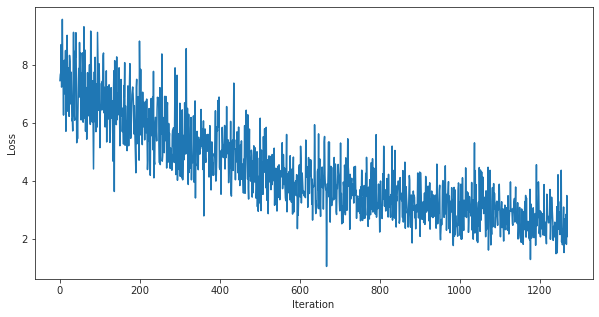

In [5]:
config = CONFIG_MODELS['TransformSinkhornPRModel']

transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

transform_sinkhorn_pr_model = TransformSinkhornPRModel(config).to(device=cuda)

criterion = nn.BCELoss()
optimizer = optim.SGD(transform_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

loss = []

for batch in data_loader:
    
    for sample in batch:
        (d, s1, s2), y = transform(sample)
        
        y_hat = transform_sinkhorn_pr_model(d.to(device=cuda),
                                            s1.to(device=cuda),
                                            s2.to(device=cuda))
        
        L = criterion(y_hat, y.to(device=cuda))
        
        L.backward()
        
        loss.append(L.item())
    
    optimizer.step()
    
    optimizer.zero_grad()
    
    print(f'Train Loss: {loss[-1]:.4f}')

transform_sinkhorn_pr_model.save('transform_sinkhorn_pr_model.pt')

n = config['batch_size']
loss = [sum(loss[i:i+n])/n for i in range(0,len(loss),n)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Neural Network - Sinkhorn - Pairwise Ranking

0.6924
0.6934
0.6965
0.6894
0.6406
0.7213
0.6958
0.6775
0.6289
0.7862
0.6715
0.6060
0.5080
0.7469
0.6727
0.7420
0.5507
0.5924
0.1673
0.7714
0.3443
0.5557
0.0608
0.5152
0.6196
0.2756
0.5135
0.9978
0.7376
0.1295
0.6931
0.5359
0.4090
0.3481
0.2921
0.3930
0.4033
0.5842
0.5009
0.1516
0.5038
0.4386
0.6030
0.8651
0.2159
0.3972
0.8491
0.4627
0.0807
0.7329
0.2894
1.2134
0.8140
0.8131
0.8613
0.5625
0.5686
0.5168
1.1267
1.0975
0.5200
0.0826
0.6904
0.2123
0.8206
0.1242
0.0897
0.5967
0.6187
0.3590
0.3026
0.6270
0.0260
0.4523
0.1786
0.6710
0.0005
0.1632
0.2430
0.3011
0.7054
0.6531
0.8222
0.3800
1.6382
0.3030
0.3493
0.4316
0.1121
0.8769
0.3617
0.9173
0.2792
1.0386
1.0830
1.2337
1.1850
0.2316
0.4155
0.5879
0.3178
0.1654
0.0719
0.6467
0.2037
0.0772
0.9883
0.3027
0.4807
0.4275
0.2042
3.3143
1.1843
0.1843
0.7871
0.4997
0.0009
0.2141
0.1559
1.0308
0.1296
0.2277
0.7052
0.0558
0.2403
0.0162
0.0168
0.9156
0.6064
0.2805
0.5964
0.4422
0.1930
0.4400
0.4675
0.4036
0.6838
0.0149
1.1437
1.1294
0.6426
0.2025
0.5037

0.1715
0.0000
0.0020
0.0334
0.3457
0.0000
0.8917
0.0311
0.2881
0.4934
0.0410
0.0050
0.4525
0.0051
0.0001
1.0343
0.0003
0.5376
0.0098
0.0080
0.0011
0.0000
0.4163
0.0002
0.0026
0.4847
0.0062
0.0026
0.0007
0.0001
0.0002
0.0006
0.0213
0.0453
0.0735
0.0003
0.1111
0.3746
0.0318
1.2215
0.0802
0.0001
0.0138
0.6382
0.0001
0.0001
0.0000
0.0011
0.0032
0.0004
0.0000
0.0024
0.0003
0.0000
0.0004
0.0013
0.0877
0.0033
0.0226
0.0003
0.0000
0.0217
0.0603
0.0262
0.0000
0.9401
0.0456
0.0627
0.0001
0.0000
0.1085
0.0020
0.0000
0.0000
0.0005
0.0000
0.0154
0.0035
0.0000
0.0031
0.3716
0.0028
0.0035
0.0112
1.5935
0.0000
0.0140
0.0649
4.9258
0.0266
0.0001
1.7426
0.3680


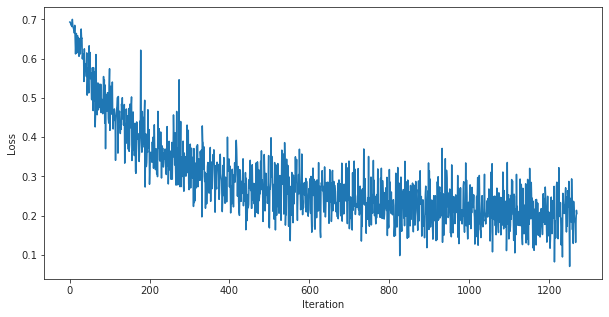

In [13]:
config = CONFIG_MODELS['NeuralNetSinkhornPRModel']

transform = transforms.Compose([Normalize(), ToTensor()])
dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).to(device=cuda)

criterion = nn.BCELoss()
optimizer = optim.Adam(neural_net_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

loss = []

for batch in data_loader:
    
    for sample in batch:
        (d, s1, s2), y = transform(sample)
        
        y_hat = neural_net_sinkhorn_pr_model(d.to(device=cuda),
                                             s1.to(device=cuda),
                                             s2.to(device=cuda))
        
        L = criterion(y_hat, y.to(device=cuda))
        
        L.backward()
        
        loss.append(L.item())
        
    optimizer.step()
    
    optimizer.zero_grad()
    
    print(f'Train Loss: {loss[-1]:.4f}')

neural_net_sinkhorn_pr_model.save('neural_net_sinkhorn_pr_model.pt')

n = config['batch_size']
loss = [sum(loss[i:i+n])/n for i in range(0,len(loss),n)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Neural Network - Scoring - Pairwise Ranking

Train Loss: 0.610487
Train Loss: 0.652655
Train Loss: 0.596007
Train Loss: 0.720684
Train Loss: 0.693901
Train Loss: 0.600038
Train Loss: 0.629797
Train Loss: 0.842802
Train Loss: 0.911343
Train Loss: 0.677394
Train Loss: 0.524346
Train Loss: 0.968464
Train Loss: 0.594893
Train Loss: 0.638874
Train Loss: 0.600763
Train Loss: 0.693610
Train Loss: 0.623731
Train Loss: 0.771990
Train Loss: 0.645862
Train Loss: 0.721404
Train Loss: 0.617681
Train Loss: 0.728795
Train Loss: 0.695551
Train Loss: 0.645824
Train Loss: 0.623006
Train Loss: 0.667699
Train Loss: 0.895075
Train Loss: 0.661467
Train Loss: 0.801924
Train Loss: 0.685834
Train Loss: 0.721177
Train Loss: 0.793704
Train Loss: 0.696864
Train Loss: 0.709371
Train Loss: 0.587841
Train Loss: 0.592738
Train Loss: 0.854100
Train Loss: 0.517641
Train Loss: 0.567865
Train Loss: 0.391559
Train Loss: 0.815562
Train Loss: 0.728357
Train Loss: 0.595920
Train Loss: 0.586864
Train Loss: 0.682634
Train Loss: 0.500554
Train Loss: 0.701677
Train Loss: 0

Train Loss: 0.864091
Train Loss: 0.519584
Train Loss: 0.184435
Train Loss: 0.439221
Train Loss: 0.750082
Train Loss: 0.538752
Train Loss: 1.272272
Train Loss: 0.452809
Train Loss: 0.302594
Train Loss: 0.650583
Train Loss: 0.623120
Train Loss: 0.487091
Train Loss: 1.170379
Train Loss: 0.399514
Train Loss: 0.983847
Train Loss: 0.849355
Train Loss: 0.333660
Train Loss: 0.409857
Train Loss: 0.219823
Train Loss: 0.765382
Train Loss: 0.171420
Train Loss: 0.722286
Train Loss: 1.340778
Train Loss: 0.610258
Train Loss: 0.397457
Train Loss: 0.307539
Train Loss: 0.618906
Train Loss: 0.030039
Train Loss: 0.288637
Train Loss: 1.084680
Train Loss: 1.163974
Train Loss: 0.399552
Train Loss: 0.594283
Train Loss: 0.464401
Train Loss: 0.431449
Train Loss: 1.097208
Train Loss: 0.414179
Train Loss: 1.096965
Train Loss: 0.393538
Train Loss: 1.381334
Train Loss: 0.367217
Train Loss: 0.410574
Train Loss: 0.478616
Train Loss: 0.318238
Train Loss: 1.474470
Train Loss: 0.195046
Train Loss: 0.428394
Train Loss: 0

Train Loss: 0.651462
Train Loss: 0.453349
Train Loss: 0.125539
Train Loss: 0.364394
Train Loss: 0.150365
Train Loss: 1.586457
Train Loss: 0.278905
Train Loss: 0.275915
Train Loss: 0.425688
Train Loss: 1.050108
Train Loss: 0.990733
Train Loss: 0.134634
Train Loss: 0.131358
Train Loss: 0.536722
Train Loss: 0.158382
Train Loss: 0.209208
Train Loss: 0.770107
Train Loss: 0.389974
Train Loss: 0.226867
Train Loss: 0.641342
Train Loss: 0.617829
Train Loss: 0.052960
Train Loss: 1.456589
Train Loss: 0.251366
Train Loss: 0.829346
Train Loss: 0.481801
Train Loss: 1.095668
Train Loss: 0.088680
Train Loss: 0.813657
Train Loss: 0.462645
Train Loss: 0.934756
Train Loss: 0.197783
Train Loss: 0.254684
Train Loss: 0.328777
Train Loss: 0.893183
Train Loss: 0.372325
Train Loss: 1.963152
Train Loss: 0.081101
Train Loss: 0.662371
Train Loss: 0.327240
Train Loss: 0.408439
Train Loss: 0.665638
Train Loss: 0.901519
Train Loss: 0.600995
Train Loss: 0.080050
Train Loss: 0.335189
Train Loss: 0.010519
Train Loss: 0

Train Loss: 0.803729
Train Loss: 0.864917
Train Loss: 0.494943
Train Loss: 0.186212
Train Loss: 0.939533
Train Loss: 0.544075
Train Loss: 0.806251
Train Loss: 0.021845
Train Loss: 0.489194
Train Loss: 0.221467
Train Loss: 0.280686
Train Loss: 0.158610
Train Loss: 1.685754
Train Loss: 0.233545
Train Loss: 0.436350
Train Loss: 0.909733
Train Loss: 1.178019
Train Loss: 0.982631
Train Loss: 0.693147
Train Loss: 0.841923
Train Loss: 0.875050
Train Loss: 0.100376
Train Loss: 0.458986
Train Loss: 0.727818
Train Loss: 0.360681
Train Loss: 0.882471
Train Loss: 0.453853
Train Loss: 0.690980
Train Loss: 0.260065
Train Loss: 0.387336
Train Loss: 0.071618
Train Loss: 0.670168
Train Loss: 0.607838
Train Loss: 0.156702
Train Loss: 0.354219
Train Loss: 0.450716
Train Loss: 0.105885
Train Loss: 0.811737
Train Loss: 0.687665
Train Loss: 0.161349
Train Loss: 0.115829
Train Loss: 1.019825
Train Loss: 0.063816
Train Loss: 0.145719
Train Loss: 0.330622
Train Loss: 1.200460
Train Loss: 0.590072
Train Loss: 1

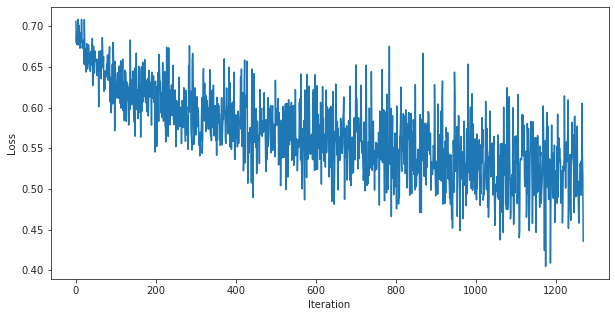

In [6]:
config = CONFIG_MODELS['NeuralNetScoringPRModel']

transform = transforms.Compose([ToTensor()])
dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).to(device=cuda)

criterion = nn.BCELoss()
optimizer = optim.SGD(neural_net_scoring_pr_model.parameters(), lr=config['learning_rate'])

loss = []

for batch in data_loader:

    for sample in batch:
        (d, s1, s2), y = transform(sample)
        
        y_hat = neural_net_scoring_pr_model(d.to(device=cuda),
                                            s1.to(device=cuda),
                                            s2.to(device=cuda))
        
        L = criterion(y_hat, y.to(device=cuda))
        
        L.backward()
        
        loss.append(L.item())
        
    optimizer.step()

    optimizer.zero_grad()

    print(f'Train Loss: {loss[-1]:4f}')

neural_net_scoring_pr_model.save('neural_net_scoring_pr_model.pt')

n = config['batch_size']
loss = [sum(loss[i:i+n])/n for i in range(0,len(loss),n)]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Neural Network - ROUGE - Regression

In [3]:
evaluator = rouge.Rouge(metrics=['rouge-n'],
                        max_n=2,
                        length_limit=100,
                        length_limit_type='words')

topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

dataset = defaultdict(dict)

for topic_id in topic_ids:
    topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
    document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

    dataset[topic_id]['document_embs'] = np.array(document_embs)
    dataset[topic_id]['summary_embs'] = np.array(summary_embs)
    dataset[topic_id]['indices'] = np.array(indices)
    dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
    dataset[topic_id]['summ_ids'] = np.array(summ_ids)

def make_tuples_data_for_regression(base_data_dir, dataset_id, topic_id):
    topic = load_data(base_data_dir, dataset_id, encoded=False)[topic_id]
    documents, summaries, indices, _, _ = extract(topic)
    reference_summaries = summaries[indices[-4][0]:indices[-1][1]]

    data = []
    n = len(documents) 
    for i in range(n):
        y = evaluator.get_scores(documents[i], reference_summaries)['rouge-2']['r']
        data.append((topic_id, i, y))

    return data

In [4]:
tuples_data = []
for topic_id in topic_ids:
    tuples_data.extend(make_tuples_data_for_regression(BASE_DATA_DIR, DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_train_regression, tuples_val_regression = stratified_sampling(tuples_data)

tuples_train_regression.shape, tuples_val_regression.shape

((7721, 3), (3309, 3))

In [5]:
class TACDatasetRegression(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        topic_id = self.data[idx][0]

        i = int(self.data[idx][1])

        s = dataset[topic_id]['document_embs'][i]
        y = float(self.data[idx][2])

        return self.transform((s, y))


class ToTensor():

    def __call__(self, sample):
        s, y = sample

        s = torch.tensor(s, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)

        return s, y


class NeuralNetRougeRegModel(nn.Module):

    @staticmethod
    def load(fname, config):
        model = NeuralNetRougeRegModel(config)
        model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
        model.eval()
        return model

    def save(self, fname):
        torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

    def __init__(self, config):
        super(NeuralNetRougeRegModel, self).__init__()
        self.config = config
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
        self.layer = nn.Linear(self.config['D'], self.config['D'])

    def transform(self, x):
        return F.relu(self.layer(x))

    def predict(self, d, s):
        return self.sinkhorn(self.transform(d), self.transform(s))

    def forward(self, sent):
        return torch.norm(self.transform(sent), p=2, dim=1)

Train Loss: 15.1608
Train Loss: 14.2341
Train Loss: 8.4686
Train Loss: 9.4920
Train Loss: 9.6046
Train Loss: 10.2888
Train Loss: 11.4987
Train Loss: 8.2514
Train Loss: 7.9272
Train Loss: 11.2611
Train Loss: 10.6856
Train Loss: 9.8037
Train Loss: 7.9328
Train Loss: 10.0795
Train Loss: 9.2268
Train Loss: 9.7532
Train Loss: 8.7996
Train Loss: 9.5630
Train Loss: 9.2324
Train Loss: 8.4474
Train Loss: 7.9917
Train Loss: 8.6573
Train Loss: 9.5830
Train Loss: 8.5590
Train Loss: 7.0236
Train Loss: 10.4694
Train Loss: 7.2101
Train Loss: 10.2660
Train Loss: 9.9021
Train Loss: 7.8950
Train Loss: 7.5996
Train Loss: 8.1045
Train Loss: 7.9629
Train Loss: 10.4365
Train Loss: 8.8280
Train Loss: 9.5947
Train Loss: 7.2972
Train Loss: 8.8932
Train Loss: 9.4846
Train Loss: 7.1310
Train Loss: 7.1375
Train Loss: 6.5873
Train Loss: 9.1693
Train Loss: 9.7588
Train Loss: 9.8748
Train Loss: 8.8900
Train Loss: 8.6875
Train Loss: 8.3737
Train Loss: 9.5029
Train Loss: 8.5401
Train Loss: 6.6785
Train Loss: 8.6104
Tr

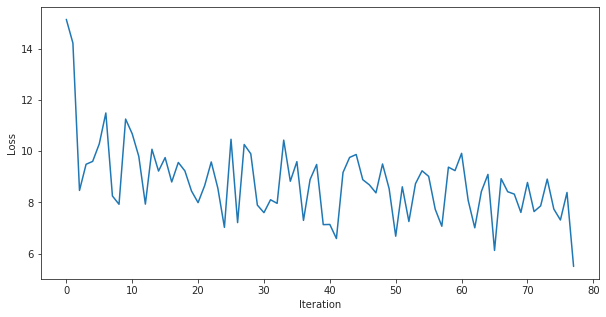

In [11]:
config = {
    'D': 768,
    'p': 2,
    'blur': .05,
    'scaling': .9,
    'learning_rate': 1e-2,
    'batch_size': 100
}

transform = transforms.Compose([ToTensor()])
dataset_train = TACDatasetRegression(tuples_train_regression, transform)
data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

neural_net_rouge_reg_model = NeuralNetRougeRegModel(config).to(device=cuda)

criterion = nn.MSELoss()
optimizer = optim.SGD(neural_net_rouge_reg_model.parameters(), lr=config['learning_rate'])

loss = []

for batch in data_loader_train:            
    optimizer.zero_grad()

    s, y = batch

    y_hat = neural_net_rouge_reg_model(s.to(device=cuda))
    y = -torch.log(y + 0.00001).to(device=cuda)

    L = criterion(y_hat, y)

    L.backward()

    optimizer.step()

    loss.append(L.item())

    print(f'Train Loss: {loss[-1]:.4f}')

neural_net_rouge_reg_model.save(f'neural_net_rouge_reg_model.pt')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
plot_loss(ax, loss)
plt.show()

## Models correlation

D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811
D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811
D0841
D0804
D0802
D0809
D0819
D0825
D0828
D0826
D0843
D0829
D0813
D0807
D0812
D0820
D0835
D0823
D0847
D0848
D0810
D0822
D0845
D0844
D0839
D0814
D0824
D0821
D0827
D0846
D0818
D0834
D0805
D0817
D0831
D0815
D0836
D0806
D0808
D0837
D0803
D0830
D0838
D0840
D0842
D0832
D0816
D0801
D0833
D0811


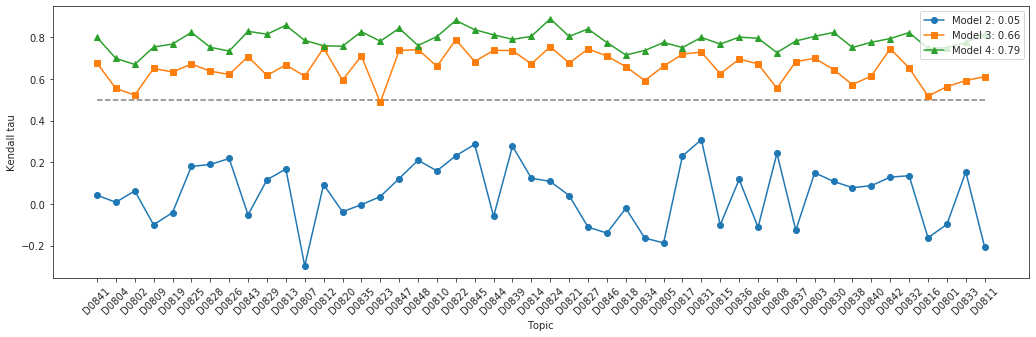

In [3]:
def experiment(model, data):
    document_embs, summary_embs, indices, pyr_scores, summ_ids = data
    document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
    metric = lambda i: model.predict(document_embs,
                                     torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def execute_experiment(model, experiment):
    scores = []
    with torch.no_grad():
        for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
            print(topic_id)
            topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
            data = extract(topic)
            scores.append(experiment(model, data))
    return np.array(scores)

models = [
    TransformSinkhornRegModel.load('transform_sinkhorn_reg_model.pt', CONFIG_MODELS['TransformSinkhornRegModel']).to(device=cuda),
    TransformSinkhornPRModel.load('transform_sinkhorn_pr_model.pt', CONFIG_MODELS['TransformSinkhornPRModel']).to(device=cuda),
    NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model.pt', CONFIG_MODELS['NeuralNetSinkhornPRModel']).to(device=cuda),
]

scores = [
    execute_experiment(models[0], experiment),
    execute_experiment(models[1], experiment),
    execute_experiment(models[2], experiment),
]

topic_ids = TOPIC_IDS[DATASET_ID_TRAIN]
x = np.arange(len(topic_ids))
fig = plt.figure(figsize=(17.5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(x, -scores[0], '-o', label=f'Model 2: {np.mean(-scores[0]):.2f}')
ax.plot(x, -scores[1], '-s', label=f'Model 3: {np.mean(-scores[1]):.2f}')
ax.plot(x, -scores[2], '-^', label=f'Model 4: {np.mean(-scores[2]):.2f}')
ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
ax.set_xticks(x)
ax.set_xticklabels(topic_ids, rotation=45)
ax.set_xlabel('Topic')
ax.set_ylabel('Kendall tau')
ax.legend(loc='upper right')
fig.savefig(os.path.join(PLOTS_DIR, f'models_correlation_1.png'), dpi=fig.dpi, bbox_inches='tight')